## Intuiciones respecto a la relacion entre bias / variance / underfitting y overfitting

Generemos esto con un dataset sintético con una relacion cuadratica entre `x` e `y`

In [1]:
import numpy as np

def sample_data(size=100, x_matrix=False):
    x = (np.random.random(size=size) - 0.5 ) * 5
    x.sort() # util para graficar
    y = x ** 2 + x + np.random.normal(0, 1, size=size)
    if x_matrix:
        x = x.reshape((-1,1))
    return x, y

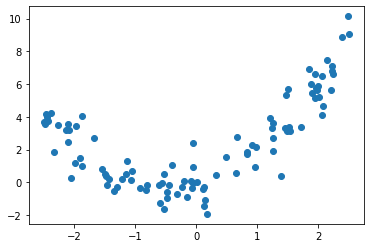

In [6]:
import matplotlib.pyplot as plt

X, y = sample_data(size=100, x_matrix=True)
plt.scatter(X, y)

# Underfitting

Vamos a ajustar esta función cuadratica con una regresion lineal

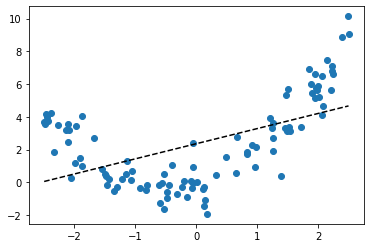

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X, y)

m, M = X.min(), X.max()

plt.plot([m, M], lr.predict([[m], [M]]), '--k')
plt.scatter(X, y)

# High bias, fiteamos muchos modelos lineales

In [8]:
def sample_predictions(model, x, iters=100):
    """
    Toma `iters` muestras de datos, entrena un modelo con esos datos 
    Devuelve el promedio de las predicciones de los modelos
    """
    ys_hat = []
    for _ in range(iters):
        X_train, y_train = sample_data(100, x_matrix=True)
        model.fit(X_train, y_train)
        ys_hat.append(model.predict(x))
    return np.asarray(ys_hat)

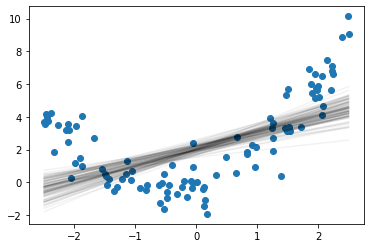

In [9]:
ys = sample_predictions(LinearRegression(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

# Overfitting

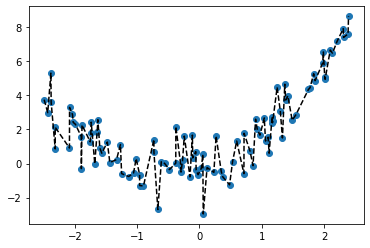

In [10]:
from sklearn.tree import DecisionTreeRegressor

X_train, y_train = sample_data(100, x_matrix=True)
lr = DecisionTreeRegressor().fit(X_train, y_train)

plt.plot(X_train, lr.predict(X_train), '--k')
plt.scatter(X_train, y_train)

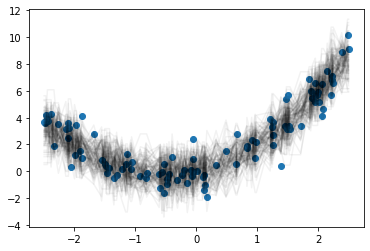

In [11]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

In [12]:
def expected_prediction(model, x, iters=100):
    return sample_predictions(model, x, iters=iters).mean(axis=0)

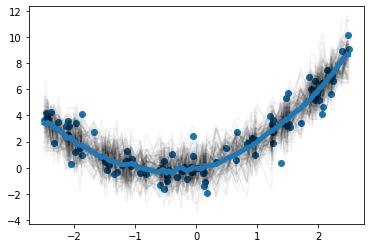

In [13]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(X, expected_prediction(DecisionTreeRegressor(), X), lw=5)

# Calculando sesgo y varianza

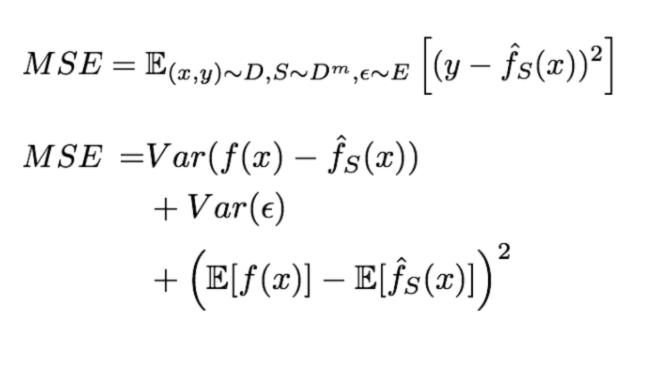

In [14]:
def bias(model, x, y, iters=100):
    expected_y = (x**2 + x).squeeze()
    expected_error = (
        expected_y - expected_prediction(model, x, iters=iters)
    ) ** 2
    return expected_error.mean()

def variance(model, x, y, iters=100):
    expected_y = (x**2 + x).squeeze()
    # repetimos la esperanza en `iters` filas para facilitar el computo
    expected_y = np.repeat(expected_y.reshape((1, -1)), iters, axis=0)
    
    # sampleamos iters predicciones de modelos
    ys_hat = sample_predictions(model, x, iters=iters)
    
    # Estimamos la varianza
    return np.var(expected_y - ys_hat, axis=0).mean()

In [15]:
bias(LinearRegression(), *sample_data(1000, x_matrix=True))

3.363561156192768

In [16]:
variance(LinearRegression(), *sample_data(1000, x_matrix=True))

0.1247109148258641

In [17]:
bias(DecisionTreeRegressor(), *sample_data(1000, x_matrix=True), iters=1000)

0.0018460484230561562

In [18]:
variance(DecisionTreeRegressor(), *sample_data(1000, x_matrix=True), iters=1000)

1.0212583941176498